In [21]:
#importing useful packages and modules
import numpy as np
import gala.potential as gp
from gala.units import galactic, solarsystem
import astropy.units as u
from astropy.coordinates.matrix_utilities import rotation_matrix
import astropy.coordinates as coord
import gala.coordinates as gc
import astropy.coordinates as ac
import gala.dynamics as gd
import gala.integrate as gi
import matplotlib as mpl
import galstreams

from gala.dynamics import mockstream as ms
from matplotlib import pyplot as plt
_ = coord.galactocentric_frame_defaults.set('v4.0')

# Setting bar & no bar MW Potentials

In [22]:
#MW Potential- bar, bulge

disk = gp.MiyamotoNagaiPotential(m=1E11, a=6.5, b=0.27, units=galactic)
halo = gp.NFWPotential(m=5E11,r_s=18,b=0.94,units=galactic) #is b = q in Pearson et al.2017??
bulge = gp.HernquistPotential(m=3E10, c=0.7, units=galactic)

bar_static= gp.LongMuraliBarPotential(m=1E10, a=3.5,b=0.5,c=0.5,alpha=-27*u.deg,units=galactic)# parameters from gala

#specifying rotation
R_array = rotation_matrix(60*u.deg, 'z')
bar_dynamic = gp.LongMuraliBarPotential(m=1E10, a=3.5,b=0.5,c=0.5,alpha=-27*u.deg,units=galactic,R=R_array)

pot2_static = gp.CCompositePotential(disk=disk,halo=halo,bulge=bulge,bar=bar_static)
pot2_dynamic= gp.CCompositePotential(disk=disk,halo=halo,bulge=bulge,bar=bar_dynamic)

In [23]:
#MW Potential- no bar, bulge

disk = gp.MiyamotoNagaiPotential(m=1E11, a=6.5, b=0.27, units=galactic)
halo = gp.NFWPotential(m=5E11,r_s=18,b=0.94,units=galactic) #is b = q in Pearson et al.2017??
bulge = gp.HernquistPotential(m=3E10, c=0.7, units=galactic)


pot3 = gp.CCompositePotential(disk=disk,halo=halo,bulge=bulge)

In [24]:
xyz = np.zeros((3, 1024))
xyz[0] = np.linspace(0, 25, xyz.shape[1])

np.where( (xyz[0]>7.99) & (xyz[0]<8.01))

(array([327], dtype=int64),)

In [25]:
#rotation
barred_pot = pot2_static 
vcirc = barred_pot.circular_velocity(xyz)
print(vcirc[327])



244.13606978861534 km / s


In [26]:
no_bar_pot = pot3
barred_pot = pot2_static
#setting pattern speed
pat_speed = 42. * u.km/u.s/u.kpc

In [27]:
#setting up rotating reference frame 
#setting Hamiltonian object
static_frame = gp.StaticFrame(galactic)
rot_frame = gp.ConstantRotatingFrame(pat_speed * [0,0,-1], units=barred_pot.units)
rot_barred_pot = gp.Hamiltonian(barred_pot, rot_frame)
no_bar_pot = gp.Hamiltonian(no_bar_pot, static_frame)

In [28]:
index = np.nanargmin(np.abs(pat_speed*xyz[0]*u.kpc - vcirc)) # parameters for sun's orbit account for the rotating reference frame
v0 = vcirc[index]
R0 = xyz[0][index]
R0, v0

(5.840664711632454, <Quantity 244.80042269 km / s>)

# Setting constants and functions

In [29]:
#setting constant mass parameter for streams' progenitor

const_pro_mass = 3e4 * u.Msun #Boyles J. et al. 2011
const_pro_pot = gp.PlummerPotential(m=const_pro_mass, b=4*u.pc, units=galactic)

#setting distribution function
df = ms.FardalStreamDF()

v_sun = coord.CartesianDifferential([8.4, 244.8, 8.4]*u.km/u.s)
galcen_frame = coord.Galactocentric(galcen_distance=8.275*u.kpc,
                                    galcen_v_sun=v_sun)



In [30]:
mws = galstreams.MWStreams(verbose=False, implement_Off=False)

Initializing galstreams library from master_log... 


In [31]:
def generate_stream(stream_pro,df,pot,const_pro_pot,const_pro_mass,step,nsteps):
    #setting initial conditions such that progenitor ends up in the present position of the cluster

    stream_pro = stream_pro

    #convert to galactocentric coordinates and get 6D 
    stream_w0 = gd.PhaseSpacePosition(stream_pro.transform_to(galcen_frame).cartesian)

    #creating mockstream
    gen_stream = ms.MockStreamGenerator(df, pot,
                                      progenitor_potential=const_pro_pot)
    stream, pro_now = gen_stream.run(stream_w0, const_pro_mass,
                                  dt=-step * u.Myr, n_steps=nsteps, release_every=1, n_particles=1) #5 Gyr
    return stream, pro_now

In [32]:
# def check_jacobi(orbit_bar):
#     omega = pat_speed * [0,0,-1]

#     Ebar = orbit_bar.energy(rot_barred_pot)
#     delta_Ebar = Ebar[:] - Ebar[0]
    
#     Lx, Ly, Lz = orbit_bar.angular_momentum()
#     Lbar = orbit_bar.angular_momentum()
#     delta_Lbar = Lbar[:,:] - Lbar[:,0:1]
#     delta_jacobi_bar = delta_Ebar - np.dot(omega, delta_Lbar)
    
#     jacobi_bar = Ebar - (omega[-1] * Lz) 
#     fractional_delta_jacobi_bar = delta_jacobi_bar / jacobi_bar
    
#     #print(jacobi_bar)
#     #print(Ebar)

#     plt.plot(orbit_bar.t, fractional_delta_jacobi_bar, label="abs maximum= " + str(np.round(np.max(np.abs(fractional_delta_jacobi_bar)), 5)))
#     plt.xlabel("time") 
#     plt.ylabel('$\Delta$E$_J$/E$_J$') 
#     plt.title("Showing Conservation of Jacobi Energy in barred MW Potential")
#     plt.legend()
#     plt.show()

In [35]:
def check_jacobi(orbit_bar):
    omega = pat_speed * [0,0,1]

    jacobi_energy = rot_barred_pot.energy(orbit_bar)
    delta_jacobi_energy = jacobi_energy[:] - jacobi_energy[0]
    
    fractional_delta_jacobi_bar = delta_jacobi_energy / jacobi_energy[0]
    
    return orbit_bar.t, fractional_delta_jacobi_bar

In [36]:
def create_orbit(stream_pro, timestep, t_orbit):
    stream_w0_bar = gd.PhaseSpacePosition(stream_pro.transform_to(galcen_frame).cartesian)
    stream_orbit_bar = rot_barred_pot.integrate_orbit(stream_w0_bar, dt=timestep*u.Myr, t1=0, t2=t_orbit*u.Gyr)
    
    stream_w0_nobar = gd.PhaseSpacePosition(stream_pro.transform_to(galcen_frame).cartesian)
    stream_orbit_nobar = no_bar_pot.integrate_orbit(stream_w0_nobar, dt=timestep*u.Myr, t1=0, t2=t_orbit*u.Gyr)
    
    return stream_orbit_bar, stream_orbit_nobar


# Stream Simulations

# Palomar 5

In [37]:
pal5_pro = coord.ICRS(ra=229.65*u.degree, dec= 0.26*u.degree, #malhan et al. 2022 (also, consider using skycoord)
                   distance=20.16*u.kpc, #malhan et al. 2022 
                   pm_ra_cosdec= -2.75*u.mas/u.yr, #malhan et al. 2022
                   pm_dec=-2.68*u.mas/u.yr, #malhan et al. 2022
                   radial_velocity= -57.03*u.km/u.s) #malhan et al. 2022


In [38]:
pal5_orbit_bar1,pal5_orbit_nobar1 = create_orbit(pal5_pro,0.1,1)
time1, change1 = check_jacobi(pal5_orbit_bar1)

In [39]:
pal5_orbit_bar2,pal5_orbit_nobar2 = create_orbit(pal5_pro,0.05,1)
time2, change2 = check_jacobi(pal5_orbit_bar2)

In [40]:
pal5_orbit_bar3,pal5_orbit_nobar3 = create_orbit(pal5_pro, 0.025,1)
time3, change3 = check_jacobi(pal5_orbit_bar3)

In [41]:
pal5_orbit_bar4,pal5_orbit_nobar4 = create_orbit(pal5_pro, 0.01, 1)
time4, change4 = check_jacobi(pal5_orbit_bar4)

In [42]:
rot_barred_pot.energy(pal5_orbit_bar1)

<Quantity [-0.14358235, -0.14358235, -0.14358235, ..., -0.14358235,
           -0.14358235, -0.14358235] kpc2 / Myr2>

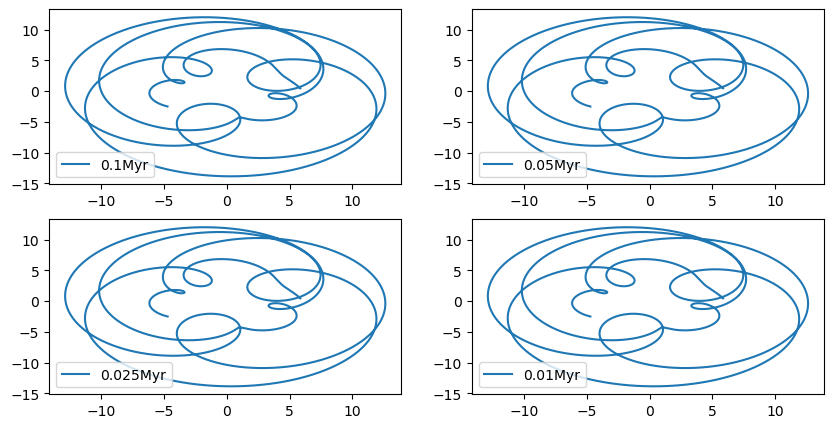

In [58]:
fig, ax = plt.subplots(2,2, figsize=(10,5))
ax[0,0].plot(pal5_orbit_bar1.x, pal5_orbit_bar1.y, label="0.1Myr")
ax[0,1].plot(pal5_orbit_bar2.x, pal5_orbit_bar2.y, label="0.05Myr")
ax[1,0].plot(pal5_orbit_bar3.x, pal5_orbit_bar3.y, label="0.025Myr")
ax[1,1].plot(pal5_orbit_bar4.x, pal5_orbit_bar4.y, label="0.01Myr")
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
plt.show()

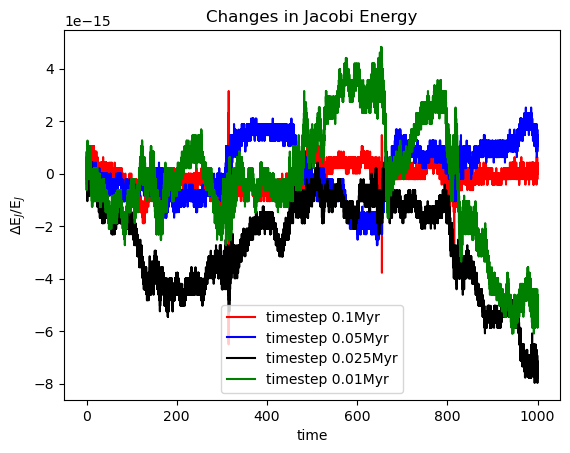

In [51]:
fig, ax = plt.subplots()
ax.plot(time1, change1, c='red', label="timestep 0.1Myr")
ax.plot(time2, change2, c='blue', label="timestep 0.05Myr")
ax.plot(time3, change3, c='black', label="timestep 0.025Myr") 
ax.plot(time4, change4, c='green', label="timestep 0.01Myr") 

ax.set_xlabel("time") 
ax.set_ylabel('$\Delta$E$_J$/E$_J$') 
ax.set_title("Changes in Jacobi Energy")
ax.legend()
plt.show()

# Ophiuchus

In [44]:
ophiuchus_pro = coord.ICRS(ra=242.04*u.degree, dec= -6.61*u.degree, 
                   distance=8.2*u.kpc, 
                   pm_ra_cosdec= -6.63*u.mas/u.yr, 
                   pm_dec=-4.37*u.mas/u.yr, 
                   radial_velocity= 289.1*u.km/u.s) 

In [45]:
ophiuchus_orbit_bar1,ophiuchus_orbit_nobar1 = create_orbit(ophiuchus_pro,0.1,1)
time1, change1 = check_jacobi(ophiuchus_orbit_bar1)

In [46]:
ophiuchus_orbit_bar2,ophiuchus_orbit_nobar2 = create_orbit(ophiuchus_pro,0.05,1)
time2, change2 = check_jacobi(ophiuchus_orbit_bar2)

In [47]:
ophiuchus_orbit_bar3,ophiuchus_orbit_nobar3 = create_orbit(ophiuchus_pro, 0.025,1)
time3, change3 = check_jacobi(ophiuchus_orbit_bar3)

In [48]:
ophiuchus_orbit_bar4,ophiuchus_orbit_nobar4 = create_orbit(ophiuchus_pro, 0.01, 1)
time4, change4 = check_jacobi(ophiuchus_orbit_bar4)

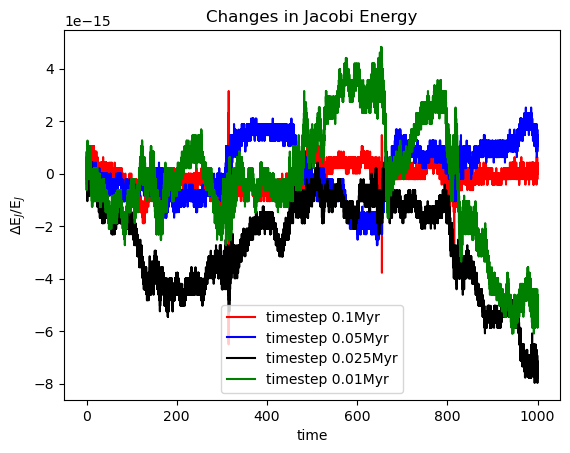

In [52]:
fig, ax = plt.subplots()
ax.plot(time1, change1, c='red', label="timestep 0.1Myr")
ax.plot(time2, change2, c='blue', label="timestep 0.05Myr")
ax.plot(time3, change3, c='black', label="timestep 0.025Myr")
ax.plot(time4, change4, c='green', label="timestep 0.01Myr")

ax.set_xlabel("time") 
ax.set_ylabel('$\Delta$E$_J$/E$_J$') 
ax.set_title("Changes in Jacobi Energy")
ax.legend()
plt.show()